<a id='top'></a>
<h1 style="font-family:Bahnschrift Condensed;text-align:center; font-size:240%;">Mauritanian Number-plate recognition challenge</h1>
<h2 style="font-family:Bahnschrift Condensed;text-align:center; font-size:240%;">2024 National Data Science Competition by RIMAI: License Plate Recognition in Mauritania - Data Science Phase</h2>
<div style="text-align:center;">
    <img src="https://www.rim-ai.com/assets/logo.png" style="width:30%; height:auto;" alt="Logo RIM AI">
</div>

- **El Moustapha Cheikh Jiddou** 
- **Pseudo: Jiddou26**
- **Email:** elmoustapha.cheikh.jiddou@gmail.com

<p style="font-family:Bahnschrift Condensed;font-size:120%; text-align:justify;">
    The second phase of the 2024 National Data Science Competition by RIMAI shifts the focus to the heart of the challenge: data science. After gathering diverse and high-quality images in the first phase, this stage is dedicated to developing and fine-tuning algorithms for the automatic recognition of Mauritanian license plates.
</p>

<p style="font-family:Bahnschrift Condensed;font-size:120%; text-align:justify;">
    Participants are invited to leverage their data science skills to create robust models capable of accurately identifying and reading license plates under various conditions. This phase is crucial, as it will test the effectiveness of the algorithms in real-world scenarios, pushing the boundaries of AI and machine learning in the context of Mauritanian license plate recognition.
</p>

<p style="font-family:Bahnschrift Condensed;font-size:120%; text-align:justify;">
    The competition aims to drive innovation in computer vision, with a particular emphasis on enhancing the accuracy, efficiency, and scalability of the solutions. The challenge is designed not only to assess technical prowess but also to encourage creativity in overcoming the unique challenges presented by this application.
</p>


<div align="center"><span style="font-family:Bahnschrift Condensed;font-size:40px"><b>Section 1: Environment Setup</b></span></div>

In [ ]:
from ultralytics import YOLO
import cv2
import os
import easyocr
import pandas as pd
import numpy as np
import re
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt


# Load the YOLO model
model = YOLO('license_plate_detector.pt')  # Ensure you have the correct model file path
reader = easyocr.Reader(['en'])  # For reading the license plate numbers


/usr/local/lib/python3.10/dist-packages/ultralytics/nn/tasks.py:511: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(file, map_location='cpu'), file  # load


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.10/dist-packages/easyocr/detection.py:78: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(copyStateDict(torch.load(trained_model, ma

<div align="center"><span style="font-family:Bahnschrift Condensed;font-size:40px"><b>Section 3: Helper Functions</b></span></div>

In [ ]:
predictions_texts = {}
def preprocess_image(img_path):
    img = cv2.imread(img_path)
    if img is None:
        print(f"Failed to load image at path: {img_path}")
        return None
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
    return img

def correct_ocr_errors(text):
    # Define a mapping of common OCR errors
    correction_map = {
        'O': '0',
        'I': '1',
        'Z': '2',
        'S': '5',
        'B': '8'
    }
    reverse_correction_map = {v: k for k, v in correction_map.items()}

    # Apply the corrections based on position
    corrected_text = []
    for i, char in enumerate(text):
        if i == 4 or i == 5:  # Positions 4 and 5 (1-indexed)
            corrected_text.append(reverse_correction_map.get(char, char))
        else:
            corrected_text.append(correction_map.get(char, char))

    return ''.join(corrected_text)

def ensure_format(text):
    # Ensure the text follows the NNNNllNN format
    text = text.ljust(8, '0')  # Pad with '0' if text is shorter than 8 characters

    # First 4 characters should be numbers
    text = ''.join(['0' if not char.isdigit() else char for char in text[:4]]) + text[4:]

    # 5th and 6th characters should be letters, default to 'A' if they are not
    text = text[:4] + ''.join(['A' if not char.isalpha() else char for char in text[4:6]]) + text[6:]

    # Ensure the 4th character is 'A' if 'A' is detected first or only occurrence
    if 'A' in text and text.count('A') == 1:
        index_of_a = text.find('A')
        if index_of_a != 4:
            text = text[:4] + 'A' + text[5:]

    # Last 2 characters should be numbers
    text = text[:6] + ''.join(['0' if not char.isdigit() else char for char in text[6:8]])

    return text

<div align="center"><span style="font-family:Bahnschrift Condensed;font-size:40px"><b>Section 4: Detection and Reading Function</b></span></div>

In [ ]:
def detect_and_read(image, model, reader):
    results = model(image)  # Run detection
    image_height, image_width = image.shape[:2]

    text = "0000AA00"  # Default value in case of failure
    best_text = ""
    best_confidence = 0  # Initialize with zero for comparison

    for result in results:
        for idx, box in enumerate(result.boxes.xyxy):
            x1, y1, x2, y2 = map(int, box[:4])
            plate_img = image[y1:y2, x1:x2]  # Crop the plate image
            # Use EasyOCR to read text from the plate
            ocr_result = reader.readtext(plate_img)
            text = ''.join([r[1] for r in ocr_result])

            # Convert to uppercase and remove invalid characters
            text = re.sub(r'[^A-Z0-9]', '', text.upper())
            text = correct_ocr_errors(text)

            # Ensure the text follows the structure NNNNllNN with default values
            text = ensure_format(text)

            # Ensure the 5th character is either 'A' or 'B'
            if text[4] not in ['A', 'B']:
                text = text[:4] + 'A' + text[5:]  # Default to 'A' if invalid

            # Ensure the last two characters are between 00 and 13
            last_two = text[-2:]
            if not last_two.isdigit() or not (0 <= int(last_two) <= 13):
                text = text[:-2] + '00'  # Default to '00' if invalid
            confidence = result.probs[idx] if result.probs and len(result.probs) > idx else 0
            if len(text) > len(best_text) or confidence > best_confidence:
                best_text = text
                best_confidence = confidence
                best_plate_img = plate_img  # Save the best plate image


    return {'detected_text': text}

<div align="center"><span style="font-family:Bahnschrift Condensed;font-size:40px"><b>Section 5: Test and Display Functions </b></span></div>


0: 640x480 1 license_plate, 954.3ms
Speed: 10.5ms preprocess, 954.3ms inference, 25.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x480 1 license_plate, 730.7ms
Speed: 14.7ms preprocess, 730.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


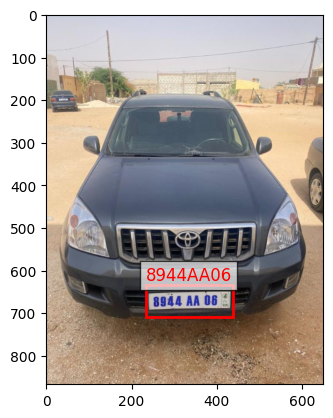

In [ ]:
#test on a specific image

import matplotlib.pyplot as plt
import matplotlib.patches as patches

def display_image_with_plate(image, results, detected_text):
    fig, ax = plt.subplots(1)
    ax.imshow(image)

    for result in results:
        for box in result.boxes.xyxy:
            x1, y1, x2, y2 = map(int, box[:4])
            # Draw the bounding box
            rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)

            # Overlay the detected text
            plt.text(x1, y1 - 10, detected_text, fontsize=12, color='red', bbox=dict(facecolor='white', alpha=0.7))

    plt.show()

def detect_and_read_with_display(img_path, model, reader):
    image = preprocess_image(img_path)
    results = model(image)

    # Use the existing detect_and_read function to get the text
    result = detect_and_read(image, model, reader)

    # Display the image with the bounding box and text
    display_image_with_plate(image, results, result['detected_text'])

# Test the new function on an image
test_image_path = '/processed_images/test_data/img_101.jpg'
detect_and_read_with_display(test_image_path, model, reader)
